In [1]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt
import h5py

import pickle
import tqdm
import time
import math

from random import choice

In [2]:
f = h5py.File('first_sample.hdf5','r')

print(f.keys())
print(f['data'].attrs.keys())
print(f['data'].attrs['title'])
print(f['data'].attrs['descr'])
print(f['data'].attrs['columns'])

rawdata = np.copy(f['data'])
f.close()

<KeysViewHDF5 ['data']>
<KeysViewHDF5 ['N', 'columns', 'descr', 'title']>
First fake dataset
Here is where we can leave notes on how we made the data set...
0-2047: wavenumber, 2048-4095: flux, z, Nar_fwhm, BLR_fwhm, BLR_fl,Nar_fl,NII_fl,Cont,Type


In [3]:
rawdata.shape

(10000, 4104)

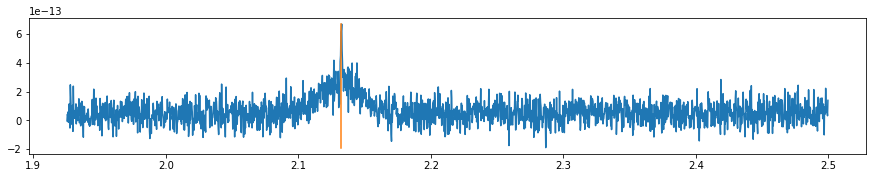

In [133]:
toshow = 1
offset = 400
plt.figure(figsize=(15,2.5*toshow))
for i in range(toshow):
    plt.subplot(toshow,1,i+1)
    x = rawdata[i+offset][   0:2048]
    y = rawdata[i+offset][2048:4096]
    plt.plot(x,y)
    opz = 1 + rawdata[i+offset][4096]
    guess = 6562.8/1e4*opz
    plt.plot([guess,guess],[np.min(y),np.max(y)])
plt.show()

## It might be good to smooth out and reduce the input size and rescale...

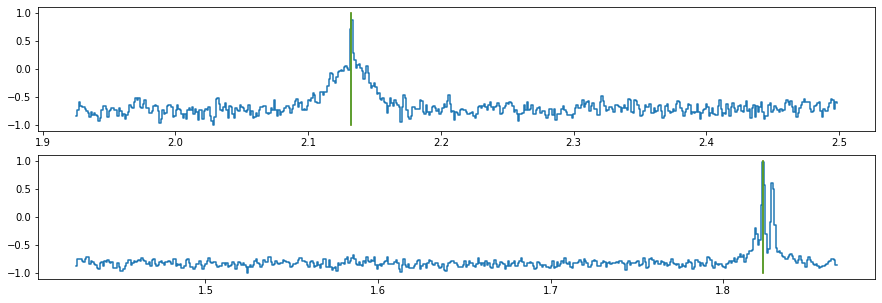

512


In [134]:
toshow = 2
offset = 400
plt.figure(figsize=(15,2.5*toshow))
for i in range(toshow):
    plt.subplot(toshow,1,i+1)
    x =  rawdata[offset + i][   0:2048]
    y0 = rawdata[offset + i][2048:4096]
    samp = np.linspace(-3,3,21)
    width = 1.0
    kernel = np.exp(-width**2*samp**2)/np.sum(np.exp(-width**2*samp**2))
    y1 = np.convolve(y0,kernel,'same')
    y1r = np.interp(y1, (y1.min(), y1.max()), (-1, +1))
    #plt.plot(x,y0)
    plt.plot(x[::4],y1r[::4],drawstyle='steps-mid')
    opz = 1 + rawdata[i+offset][4096]
    guess = 6562.8/1e4*opz
    maxpos = np.argmax(y0)*(rawdata[offset + i,2047]-rawdata[offset + i,0])/2048+rawdata[offset + i,0]
    plt.plot([guess,guess],[-1,1])
    plt.plot([maxpos,maxpos],[-1,1])
    
plt.show()
print(len(x[::4]))

In [6]:
nconvert = len(rawdata)
downsample = 4    ## for now make sure downsample divides 2048, i.e. is a power of 4
samp = np.linspace(-3,3,21)
width = 1.0
kernel = np.exp(-width**2*samp**2)/np.sum(np.exp(-width**2*samp**2))

resampledx = np.zeros((nconvert,int(2048/downsample)))
resampledy = np.zeros((nconvert,int(2048/downsample)))

for i in tqdm.tqdm(range(nconvert)):   
    y0 = rawdata[i][2048:4096]
    y1 = np.convolve(y0,kernel,'same')
    x1 = rawdata[i][   0:2048]
    y1[::downsample]
    resampledy[i] = np.interp(y1[::downsample],(y1[::downsample].min(), y1[::downsample].max()), (-1, +1))
    resampledx[i] = x1[::downsample]
    


100%|██████████| 10000/10000 [00:01<00:00, 9607.17it/s]


In [7]:
## Now figure out a reasonable measure of z: use the pixel number to remove the dependence on wavelength window

opzs = 1 + rawdata[:,4096]
peaks = 6562.8/1e4*opzs
indicesofmax_fromz = (peaks - rawdata[:,0])/((rawdata[:,2047]-rawdata[:,0])/2048*4)
indicesofmax_abs   = np.argmax(resampledy,axis=1)

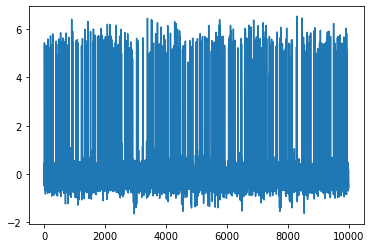

In [8]:
plt.plot((indicesofmax_abs - indicesofmax_fromz))

# Do the thing: Use NN to try to guess z

In [43]:
from keras.models import Sequential
from keras.layers import Dense

In [44]:
## Define test and training data

trainx = resampledy[0:2000]
trainy = indicesofmax_fromz[0:2000]
testx = resampledy[2000:]
testy = indicesofmax_fromz[2000:]

In [45]:
## Define a Neural network

model_001 = Sequential()
model_001.add(Dense(512, input_dim=512, activation='relu'))
model_001.add(Dense(8, activation='relu'))
model_001.add(Dense(1))
model_001.compile(loss='mean_squared_error', optimizer='adam')

model_002 = Sequential()
model_002.add(Dense(256, input_dim=512, activation='relu'))
model_002.add(Dense(64, activation='relu'))
model_002.add(Dense(16, activation='relu'))
model_002.add(Dense(1))
model_002.compile(loss='mean_squared_error', optimizer='adam')

model_003 = Sequential()
model_003.add(Dense(256, input_dim=512, activation='relu'))
model_003.add(Dense(64, activation='relu'))
model_003.add(Dense(16, activation='relu'))
model_003.add(Dense(1))
model_003.compile(loss='mean_squared_error', optimizer='adam')

model_004 = Sequential()
model_004.add(Dense(256, input_dim=512, activation='relu'))
model_004.add(Dense(128, activation='relu'))
model_004.add(Dense(32, activation='relu'))
model_004.add(Dense(1))
model_004.compile(loss='mean_squared_error', optimizer='adam')

In [46]:
model_001.fit(trainx, trainy, epochs=100, batch_size=2, verbose=0, shuffle=True, validation_split=0.2)
print("done with 001")
model_002.fit(trainx, trainy, epochs=100, batch_size=2, verbose=0, shuffle=True, validation_split=0.2)
print("done with 002")
model_003.fit(trainx, trainy, epochs=200, batch_size=2, verbose=0, shuffle=True, validation_split=0.2)
print("done with 003")
model_004.fit(trainx, trainy, epochs=100, batch_size=2, verbose=0, shuffle=True, validation_split=0.2)
print("done with 004")

done with 001
done with 002
done with 003
done with 004


In [57]:
## Evaluate Performance

trainScore = model_001.evaluate(trainx, trainy, verbose=0)
#print('Train Score (001): %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model_001.evaluate(testx, testy, verbose=0)
print('Test Score (001): %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

trainScore = model_002.evaluate(trainx, trainy, verbose=0)
#print('Train Score (002): %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model_002.evaluate(testx, testy, verbose=0)
print('Test Score (002): %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

trainScore = model_003.evaluate(trainx, trainy, verbose=0)
#print('Train Score (003): %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model_003.evaluate(testx, testy, verbose=0)
print('Test Score (003): %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

trainScore = model_004.evaluate(trainx, trainy, verbose=0)
#print('Train Score (004): %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model_004.evaluate(testx, testy, verbose=0)
print('Test Score (004): %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Test Score (001): 2761.70 MSE (52.55 RMSE)
Test Score (002): 1224.54 MSE (34.99 RMSE)
Test Score (003): 1273.25 MSE (35.68 RMSE)
Test Score (004): 1251.45 MSE (35.38 RMSE)


In [58]:
trainPredict_001 = model_001.predict(trainx)
testPredict_001 = model_001.predict(testx)
trainPredict_002 = model_002.predict(trainx)
testPredict_002 = model_002.predict(testx)
trainPredict_003 = model_003.predict(trainx)
testPredict_003 = model_003.predict(testx)
trainPredict_004 = model_004.predict(trainx)
testPredict_004 = model_004.predict(testx)

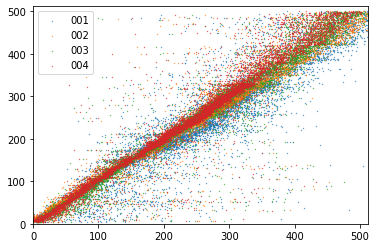

In [61]:
plt.scatter(testPredict_001[:,0],testy,s=0.1,label='001')
plt.scatter(testPredict_002[:,0],testy,s=0.1,label='002')
plt.scatter(testPredict_003[:,0],testy,s=0.1,label='003')
plt.scatter(testPredict_004[:,0],testy,s=0.1,label='004')
plt.legend()
plt.xlim(0,512)
plt.ylim(0,512)
plt.show()

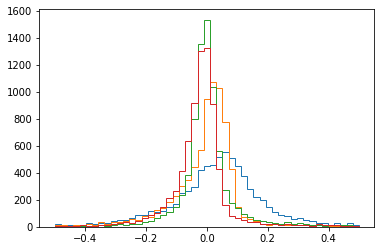

In [64]:
plt.hist((testPredict_001[:,0]-testy)/testy,bins=np.linspace(-0.5,0.5,50),histtype='step')
plt.hist((testPredict_002[:,0]-testy)/testy,bins=np.linspace(-0.5,0.5,50),histtype='step')
plt.hist((testPredict_003[:,0]-testy)/testy,bins=np.linspace(-0.5,0.5,50),histtype='step')
plt.hist((testPredict_004[:,0]-testy)/testy,bins=np.linspace(-0.5,0.5,50),histtype='step')
plt.show()

It seems to me that a broader NN was better. So I will go in that direction...

In [122]:
model_005 = Sequential()
model_005.add(Dense(512, input_dim=512, activation='relu'))
model_005.add(Dense(256, activation='relu'))
model_005.add(Dense(128, activation='relu'))
model_005.add(Dense(64, activation='relu'))
model_005.add(Dense(8, activation='relu'))
model_005.add(Dense(1))
model_005.compile(loss='mean_squared_error', optimizer='adam')

model_006 = Sequential()
model_006.add(Dense(512, input_dim=512, activation='relu'))
model_006.add(Dense(256, activation='relu'))
model_006.add(Dense(128, activation='relu'))
model_006.add(Dense(64, activation='relu'))
model_006.add(Dense(8, activation='relu'))
model_006.add(Dense(1))
model_006.compile(loss='mean_squared_error', optimizer='adam')

In [123]:
model_005.fit(trainx, trainy, epochs=200, batch_size=2, verbose=1, shuffle=True, validation_split=0.2)
print("done with 005")
model_006.fit(trainx, trainy, epochs=100, batch_size=2, verbose=1, shuffle=True, validation_split=0.2)
print("done with 006")

Epoch 1/200
800/800 [==============================] - 2s 2ms/step - loss: 19853.4058 - val_loss: 7506.4312
Epoch 2/200
800/800 [==============================] - 2s 2ms/step - loss: 7660.3728 - val_loss: 8091.6152
Epoch 3/200
800/800 [==============================] - 2s 2ms/step - loss: 7016.2860 - val_loss: 9707.4502
Epoch 4/200
800/800 [==============================] - 2s 2ms/step - loss: 6688.0893 - val_loss: 7084.9844
Epoch 5/200
800/800 [==============================] - 1s 2ms/step - loss: 5824.8546 - val_loss: 9648.9043
Epoch 6/200
800/800 [==============================] - 2s 2ms/step - loss: 5647.0070 - val_loss: 4745.6587
Epoch 7/200
800/800 [==============================] - 1s 2ms/step - loss: 3987.9234 - val_loss: 3760.2944
Epoch 8/200
800/800 [==============================] - 1s 2ms/step - loss: 3648.7589 - val_loss: 2924.0491
Epoch 9/200
800/800 [==============================] - 2s 2ms/step - loss: 2716.1430 - val_loss: 2800.7329
Epoch 10/200
800/800 [==============

In [125]:
model_007 = Sequential()
model_007.add(Dense(512, input_dim=512, activation='relu'))
model_007.add(Dense(256, activation='relu'))
model_007.add(Dense(128, activation='relu'))
model_007.add(Dense(64, activation='relu'))
model_007.add(Dense(8, activation='relu'))
model_007.add(Dense(1))
model_007.compile(loss='mean_squared_error', optimizer='adam')
history_007 = model_007.fit(trainx, trainy, epochs=100, batch_size=2, verbose=1, shuffle=True, validation_split=0.2)
print("done with 007")

Epoch 1/100
800/800 [==============================] - 2s 2ms/step - loss: 19529.2424 - val_loss: 8462.0195
Epoch 2/100
800/800 [==============================] - 2s 2ms/step - loss: 8699.6493 - val_loss: 7161.4219
Epoch 3/100
800/800 [==============================] - 2s 2ms/step - loss: 6954.1003 - val_loss: 7615.3096
Epoch 4/100
800/800 [==============================] - 1s 2ms/step - loss: 6323.8947 - val_loss: 8565.5801
Epoch 5/100
800/800 [==============================] - 1s 2ms/step - loss: 6176.3055 - val_loss: 6359.6982
Epoch 6/100
800/800 [==============================] - 1s 2ms/step - loss: 5443.5218 - val_loss: 5575.7900
Epoch 7/100
800/800 [==============================] - 2s 2ms/step - loss: 4511.9704 - val_loss: 4373.0425
Epoch 8/100
800/800 [==============================] - 2s 2ms/step - loss: 3999.5104 - val_loss: 4932.1245
Epoch 9/100
800/800 [==============================] - 2s 2ms/step - loss: 3712.7204 - val_loss: 4367.7305
Epoch 10/100
800/800 [==============

In [ ]:
trainPredict_005 = model_005.predict(trainx)
testPredict_005 = model_005.predict(testx)
trainPredict_006 = model_006.predict(trainx)
testPredict_006 = model_006.predict(testx)
trainPredict_007 = model_007.predict(trainx)
testPredict_007 = model_007.predict(testx)

In [ ]:
#plt.scatter(testPredict_004[:,0],testy,s=0.1,label='004')
plt.scatter(testPredict_005[:,0],testy,s=0.1,label='005')
plt.scatter(testPredict_006[:,0],testy,s=0.1,label='006')
plt.scatter(testPredict_007[:,0],testy,s=0.1,label='007')
plt.legend()
plt.show()

In [ ]:
confactor = 4/2048*(rawdata[2000:,2047]-rawdata[2000:,0])
mybins = np.linspace(-0.5,0.5,51)

plt.hist((testPredict_004[:,0]-testy)/(testy+rawdata[2000:,0]/confactor),bins=mybins,histtype='step',label='004')
plt.hist((testPredict_005[:,0]-testy)/(testy+rawdata[2000:,0]/confactor),bins=mybins,histtype='step',label='005')
plt.hist((testPredict_006[:,0]-testy)/(testy+rawdata[2000:,0]/confactor),bins=mybins,histtype='step',label='006')
plt.hist((testPredict_007[:,0]-testy)/(testy+rawdata[2000:,0]/confactor),bins=mybins,histtype='step',label='007')
plt.axvline(0,linewidth=1, color='k')
plt.legend()
plt.show()

In [128]:
print(history_007.history.keys())

dict_keys(['loss', 'val_loss'])


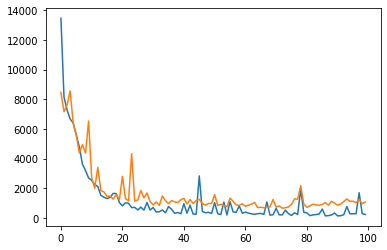

In [131]:
plt.plot(history_007.history['loss'])
plt.plot(history_007.history['val_loss'])